In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [3]:
image_path = '../images/EAN-UPC-EAN-13 MASTER GRADE IMGB.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

In [107]:
image_path = f'../images/{images_paths[26]}'#'other images/1.png'#f'../images/{images_paths[22]}'

(1024, 1280, 3)


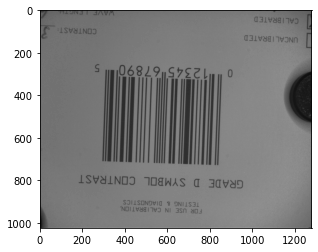

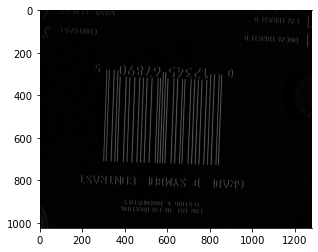

In [108]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# Find contours
kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
image_horizontal_derivative = np.abs(image_horizontal_derivative)
kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
image_vertical_derivative = np.abs(image_vertical_derivative)

image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

plt.figure()
plt.imshow(image_horizontal_derivative, 'gray')

[[       nan        nan        nan ...        nan        nan        nan]
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.19028995 1.57079633 ...        nan 1.57079633 1.57079633]
 [       nan        nan        nan ...        nan        nan        nan]]


<ipython-input-22-bcc518e3d6e1>:2: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.arctan(image_vertical_derivative/image_horizontal_derivative)
<ipython-input-22-bcc518e3d6e1>:2: RuntimeWarning: invalid value encountered in true_divide
  angle = np.arctan(image_vertical_derivative/image_horizontal_derivative)


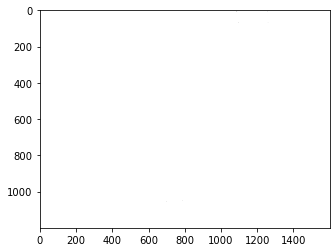

In [22]:
angle = np.zeros(gray.shape)
angle = np.arctan(image_vertical_derivative/image_horizontal_derivative)
angle[image_vertical_derivative==0] = np.nan

print(angle)

plt.figure()
plt.imshow(angle, 'gray')

In [23]:
np.median(angle[~np.isnan(angle)])

1.5707963267948966

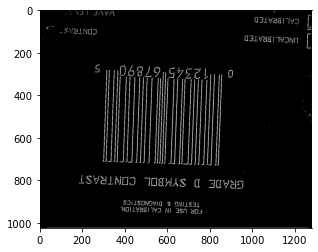

In [109]:
# Threshold, Otsu's algorithm
ret2,thresh = cv2.threshold(image_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#thresh = 255-thresh

plt.figure()
plt.imshow(thresh, 'gray')

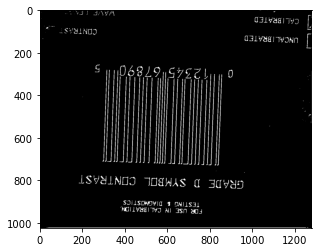

In [110]:
# Make bars more vertical
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
closed0 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed0, 'gray')

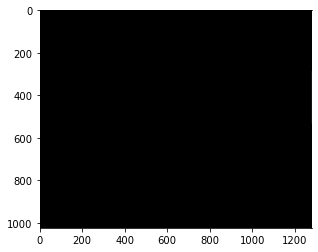

In [111]:
# Keep only vertical bars
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened = cv2.morphologyEx(closed0, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')

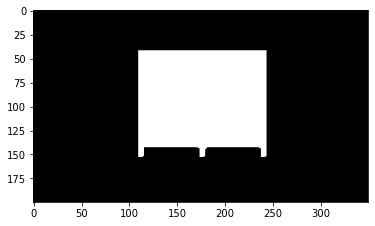

In [101]:
# OPTION A: closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

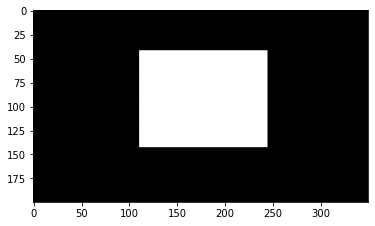

In [102]:
# Remove things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
opened1 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened1, 'gray')

#opened1 = closed

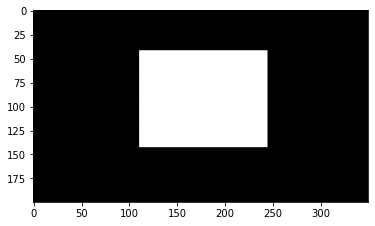

In [103]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
closed1 = cv2.morphologyEx(opened1, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed1, 'gray')

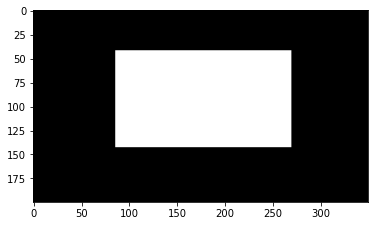

In [104]:
kernel = np.zeros((11,11),np.uint8)
kernel[5,:] = 1

dilated = cv2.dilate(opened1, kernel, iterations = 5)#cv2.dilate(opened1, kernel, iterations = 5)

plt.figure()
plt.imshow(dilated, 'gray')

((177.5, 92.0), (100.0, 183.0), 90.0)
[[ 86  42]
 [269  42]
 [269 142]
 [ 86 142]]


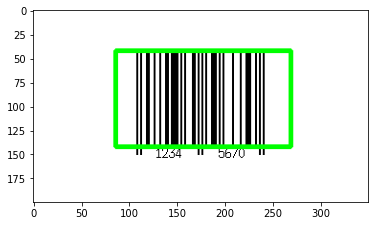

In [105]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

[(86.0, 42.0), (269.0, 42.0), (86.0, 142.0), (269.0, 142.0)]
[[ 42.  86.]
 [ 42. 269.]
 [142. 269.]
 [ 86. 142.]]


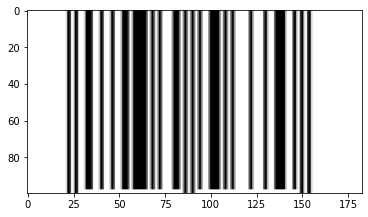

In [106]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')
print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
coordinates_destination = np.array([[0, 0],
                                    [destination_width-1, 0],
                                    [0, destination_height-1],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')